In [111]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

### Decision Tree

In [248]:
class node:
  def __init__(self, attribute: str = None, leaf: bool = False, value: str = None):
    self.attribute = attribute
    self.edges = {}
    self.leaf = leaf
    self.value = value

  def find_leaf(self, row: dict):
    if self.value:
      return self.value
    elif self.leaf:
      return self.edges[row[self.attribute]]
    else:
      return self.edges[row[self.attribute]].find_leaf(row)
    
  def add_edge(self, attribute_value: str, node):
    self.edges[attribute_value] = node
    return self.edges[attribute_value]

  def find_node(self, attribute_value: str):
    return self.edges[attribute_value]

  def set_attribute(self, attribute: str):
    self.attribute = attribute

  def set_value(self, value: str):
    self.value = value

In [259]:
class decision_tree:
  def __init__(self, dataset: pd.DataFrame, target_col: str):
    self.dataset = dataset
    self.target_col = target_col
    self.columns = dataset.columns.drop(target_col)
    self.tree = None
  
  def entropy(self, df: pd.DataFrame) -> float:
    """
    Calculate the entropy of a given attribute.

    @param df: Dataset containing only the attribute class for which we will calculate the entropy.
    """

    entropy = 0

    for target_class in df[self.target_col].unique():
      # Calculate the probability of each class
      prob = df[self.target_col].value_counts()[target_class] / len(df)

      # Calculate the entropy
      entropy -= prob * np.log2(prob)

    return entropy
  
  def information_gain(self, df: pd.DataFrame, attribute: str) -> float:
    """
    Calculate the information gain of a given attribute.

    @param df: Dataset containing only the attribute for which we will calculate the information gain.
    @param attribute: The attribute to calculate the information gain for.
    """

    # Calculate the entropy of the dataset
    entropy_dataset = 0

    for target_class in df[self.target_col].unique():
      # Calculate the probability of each class
      prob = df[df[self.target_col] == target_class][self.target_col].count() / len(df)

      # Calculate the entropy
      entropy_dataset -= prob * np.log2(prob)

    # Calculate the entropy of the attribute
    entropy_attribute = 0

    for attribute_value in df[attribute].unique():
      # Calculate the probability of each attribute value
      prob = df[attribute].value_counts()[attribute_value] / len(df)

      # Calculate the entropy of the attribute
      entropy_attribute -= prob * self.entropy(df[df[attribute] == attribute_value]) 

    return entropy_dataset + entropy_attribute

  def most_informative(self, df: pd.DataFrame) -> str:
    """
    Return the most informative attribute in a given dataset.

    @param df: Dataset containing the attributes for which we will calculate the information gain.
    """

    columns = df.columns.drop(self.target_col)
    information_gains = {}

    for attribute in columns:
      information_gains[attribute] = self.information_gain(df, attribute)

    return max(information_gains, key=information_gains.get)
  
  def is_pure(self, df: pd.DataFrame):
    """
    Check if a given attribute is pure.

    @param attribute: The attribute to check.
    """
    return len(df[self.target_col].unique()) == 1
  
  def build_tree(self, df: pd.DataFrame, current_node: node):
    """
    Build the decision tree. This is a recursive function.

    @param df: The dataset to build the tree on. On every iteration, the dataset will be reduced using the most informative attribute.
    @param current_node: The current node in the tree. On every iteration, a new node will be added to the tree. If no node is given, a new tree will be created.
    """
    # Check if there are no more attributes to split on
    if len(df.columns) == 1:
      return
    
    # Get the most informative attribute
    most_informative = self.most_informative(df)

    if not current_node:
      # Create a new node
      self.tree = node(attribute=most_informative)
      current_node = self.tree
    else:
      current_node.set_attribute(most_informative)

    for edge in df[most_informative].unique():
      # Check if the attribute is pure
      if self.is_pure(df[df[most_informative] == edge]):
        # Add a leaf node
        current_node.add_edge(edge, node(leaf=True, value=df[df[most_informative] == edge][self.target_col].iloc[0]))
      else:
        new_node = current_node.add_edge(edge, node())
        new_df = df[df[most_informative] == edge].drop(most_informative, axis=1)
        if len(new_df.columns) == 1:
          new_node.set_value(new_df[self.target_col].iloc[0])
        else:
          self.build_tree(new_df, new_node)


  def fit(self):
    """
    Fit the decision tree to the dataset.
    """

    df = self.dataset.copy()

    self.build_tree(df, current_node=None)

  def predict(self, df: pd.DataFrame):
    """
    Predict the target class of a given dataset.

    @param df: The dataset to predict the target class for.
    """
    dataset = df.to_dict('records')

    result = []

    for row in dataset:
      result.append(self.tree.find_leaf(row))

    return result

### Data Exploration

In [2]:
# Importing dataset
df = pd.read_csv('dataset/cars_india.csv')

<AxesSubplot: >

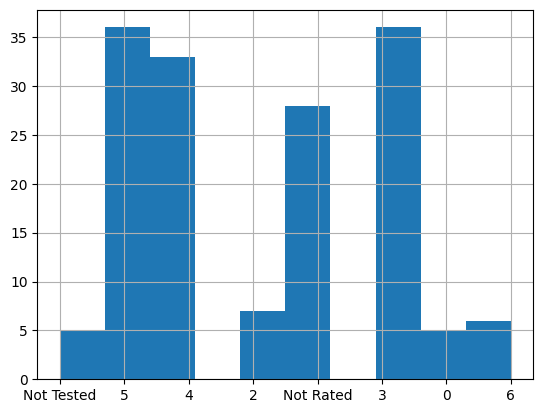

In [3]:
df["NCAP Rating"].hist()

In [4]:
df.head()

,Model,Maker,Type,Seats,Displacement,Length,Width,Height,Wheelbase,No_of_Cylinders,...,Rear Brake,Drive,Turning Radius,Fuel Tank Capacity,Boot Space,Fuel Efficiency,Emission Type,Tyre Size,Variants,NCAP Rating
0,Virtus,Volkswagen,Sedan,5,999.0,4561,1752,1507,2651,3.0,...,Drum,2WD,5.05,45.0,521.0,19.40,BS VI,205/55 R16,3,Not Tested
1,Virtus,Volkswagen,Sedan,5,999.0,4561,1752,1507,2651,3.0,...,Drum,2WD,5.05,45.0,521.0,18.12,BS VI,205/55 R16,2,Not Tested
2,Virtus,Volkswagen,Sedan,5,1498.0,4561,1752,1507,2651,4.0,...,Drum,2WD,5.05,45.0,521.0,18.67,BS VI,205/55 R16,1,Not Tested
3,Taigun,Volkswagen,Mid Size SUV,5,999.0,4221,1760,1612,2651,3.0,...,Drum,2WD,5.05,50.0,385.0,19.20,BS VI,205/55 R17,3,5
4,Taigun,Volkswagen,Mid Size SUV,5,999.0,4221,1760,1612,2651,3.0,...,Drum,2WD,5.05,50.0,385.0,17.23,BS VI,205/55 R17,2,5


In [250]:
cars_df = df[['Maker', 'Type', 'Front Brake', 'Rear Brake', 'Drive', 'NCAP Rating']]
cars_df = cars_df.dropna()

# Removing spaces from the Drive column causing difeerent values for same category
cars_df['Drive'] = cars_df['Drive'].str.replace(" ","")

### Train / Test

In [251]:
train, test = train_test_split(cars_df, test_size=0.2, random_state=42, stratify=cars_df['NCAP Rating'])

In [260]:
tree = decision_tree(train, 'NCAP Rating')

In [261]:
tree.fit()

In [ ]:
tree.predict(test)